In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
np.random.seed(1337)

In [2]:
train_file = r"D:\test_development\Battery\data1\LG_HG2_Prepared_Dataset_McMasterUniversity_Jan_2020\LGHG2@n10C_to_25degC\Train\TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.mat"
val_file = r"D:\test_development\Battery\data1\LG_HG2_Prepared_Dataset_McMasterUniversity_Jan_2020\LGHG2@n10C_to_25degC\Validation\01_TEST_LGHG2@n10degC_Norm_(05_Inputs).mat"
test_folder = r"D:\test_development\Battery\data1\LG_HG2_Prepared_Dataset_McMasterUniversity_Jan_2020\LGHG2@n10C_to_25degC\Test/"

In [3]:
mat = scipy.io.loadmat(train_file)
x_train = pd.DataFrame(mat['X']).T
y_train = pd.DataFrame(mat['Y']).T
print(x_train.shape)
print(y_train.shape)


(669956, 5)
(669956, 1)


In [4]:
mat = scipy.io.loadmat(val_file)
x_val = pd.DataFrame(mat['X']).T
y_val = pd.DataFrame(mat['Y']).T
print(x_val.shape)
print(y_val.shape)

(39293, 5)
(39293, 1)


In [5]:
x_tests = []
y_tests = []
for test_filename in os.listdir(test_folder):
    mat = scipy.io.loadmat(test_folder + test_filename)
    x_tests.append(pd.DataFrame(mat['X']).T)
    y_tests.append(pd.DataFrame(mat['Y']).T)

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


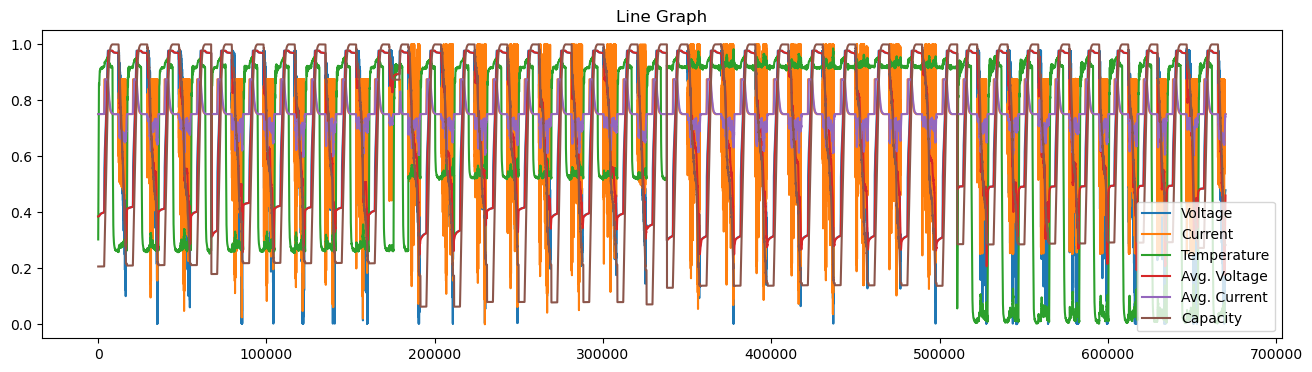

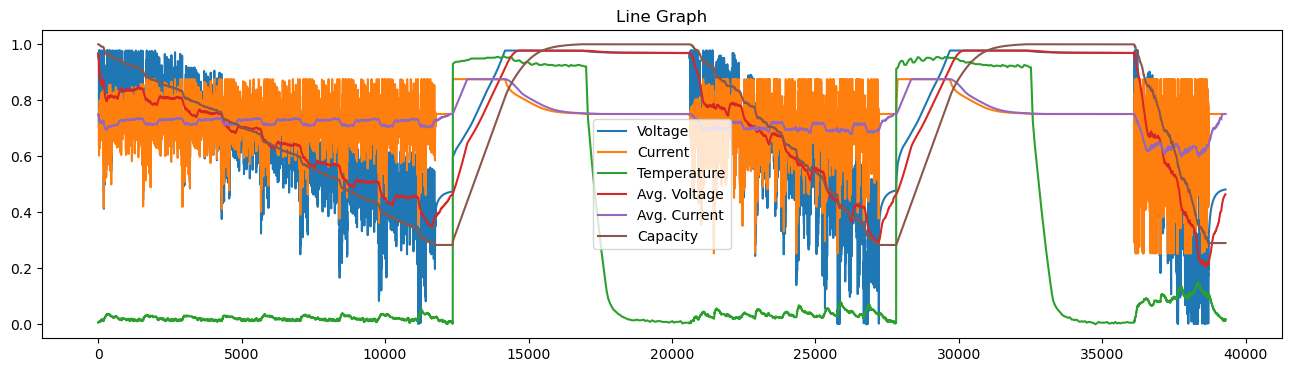

In [6]:
def train_test_plot(x, y):
    df = pd.concat([x, y], axis=1)
    df.iloc[:,0].plot(figsize=(16, 4), legend=True)
    df.iloc[:,1].plot(figsize=(16, 4), legend=True)
    df.iloc[:,2].plot(figsize=(16, 4), legend=True)
    df.iloc[:,3].plot(figsize=(16, 4), legend=True)
    df.iloc[:,4].plot(figsize=(16, 4), legend=True)
    df.iloc[:,5].plot(figsize=(16, 4), legend=True)
    plt.legend(['Voltage', 'Current', 'Temperature', 'Avg. Voltage', 'Avg. Current', 'Capacity'])
    plt.title("Line Graph")
    plt.show()

train_test_plot(x_train, y_train)
train_test_plot(x_val, y_val)

In [7]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='tanh'),
  tf.keras.layers.Dense(19, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')


history = model.fit(x_train.values, y_train.values, epochs=10, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

Train on 669956 samples, validate on 39293 samples
Epoch 1/10
669956/669956 [==============================] - 23s 35us/sample - loss: 0.0011 - val_loss: 0.0014
Epoch 2/10
669956/669956 [==============================] - 23s 34us/sample - loss: 6.7640e-04 - val_loss: 6.7471e-04
Epoch 3/10
669956/669956 [==============================] - 23s 35us/sample - loss: 6.2339e-04 - val_loss: 3.3536e-04
Epoch 4/10
669956/669956 [==============================] - 23s 35us/sample - loss: 5.8928e-04 - val_loss: 3.7533e-04


In [8]:
history.history

{'loss': [0.001128710414030984,
  0.0006763971531962853,
  0.0006233941182178927,
  0.0005892818024745382],
 'val_loss': [0.0013680572161807762,
  0.0006747139475745902,
  0.0003353644932620565,
  0.00037533450189628073]}

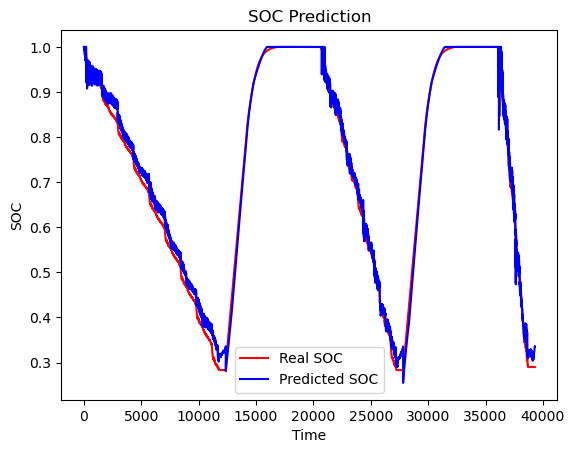

In [9]:
prediction = model.predict(x_tests[0])

# Visualising the results
plt.plot(y_tests[0], color = 'red', label = 'Real SOC')
plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
plt.title('SOC Prediction')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()
plt.show()

In [13]:
other_folder = r"D:\test_development\Battery\data1\LG_HG2_Prepared_Dataset_McMasterUniversity_Jan_2020\LGHG2@n10C_to_25degC\Other_Files/"

x_others = []
y_others = []
for other_filename in os.listdir(other_folder):
    if not other_filename.startswith('TRAIN'):
        continue
    mat = scipy.io.loadmat(other_folder + other_filename)
    x_others.append(pd.DataFrame(mat['X']).T)
    y_others.append(pd.DataFrame(mat['Y']).T)

In [ ]:
for i in range(len(x_others)):
    prediction = model.predict(x_others[i])

    plt.figure(figsize=(18, 6))

    # Visualising the results
    plt.plot(y_others[i], color = 'red', label = 'Real SOC')
    plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
    plt.title('SOC Prediction')
    plt.xlabel('Time')
    plt.ylabel('SOC')
    plt.legend()
    plt.show()
    model.evaluate(x_others[i], y_others[i])

In [15]:
extra_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\10degC\all.csv"
extra_df = pd.read_csv(extra_file, usecols=['Voltage', 'Current', 'Temperature', 'Capacity'])
extra_df = extra_df[1:].astype(float).round(5)
x_extra = extra_df[['Voltage', 'Current', 'Temperature']]
y_extra = extra_df['Capacity']

In [16]:
x_extra = (x_extra - x_extra.min()) / (x_extra.max() - x_extra.min())
y_extra = (y_extra - y_extra.min()) / (y_extra.max() - y_extra.min())

x_extra.fillna(method='ffill', inplace=True)
y_extra.fillna(method='ffill', inplace=True)

In [17]:
b, a = scipy.signal.butter(1, 0.001, btype='lowpass', output='ba')
x_extra['Avg. Voltage'] = scipy.signal.filtfilt(b, a, x_extra.loc[:,'Voltage'])
b, a = scipy.signal.butter(1, 0.01, btype='lowpass', output='ba')
x_extra['Avg. Current'] = scipy.signal.filtfilt(b, a, x_extra.loc[:,'Current'])

#x_extra['Avg. Voltage'] = np.convolve(x_extra['Voltage'], np.ones(50)/50, mode='same')
#x_extra['Avg. Current'] = np.convolve(x_extra['Current'], np.ones(50)/50, mode='same')

c:\Users\user\anaconda3\envs\sfdd\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


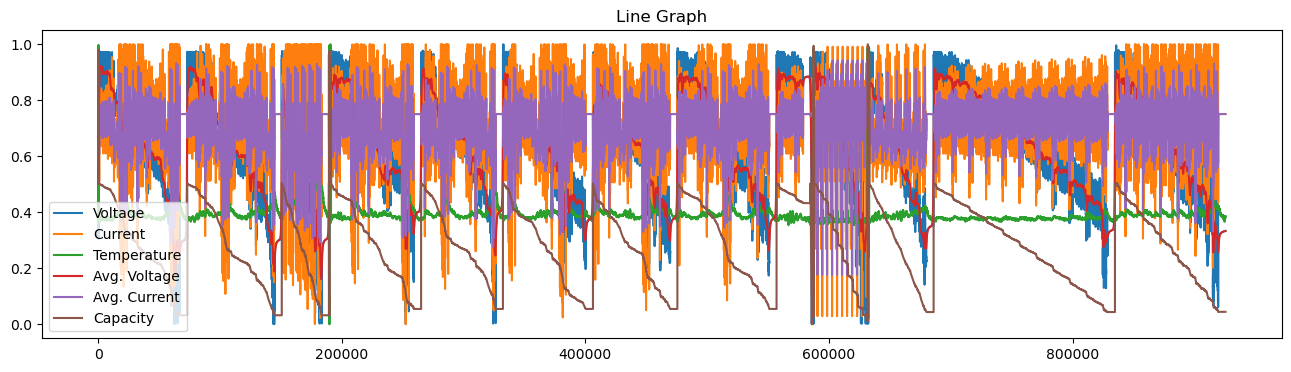

In [18]:
train_test_plot(x_extra, y_extra)

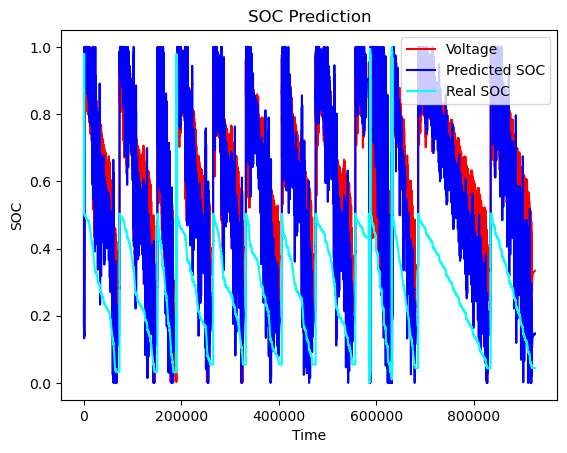

In [19]:
prediction = model.predict(x_extra)

# Visualising the results
plt.plot(x_extra['Voltage'], color = 'red', label = 'Voltage')
plt.plot(prediction, color = 'blue', label = 'Predicted SOC')
plt.plot(y_extra, color = 'cyan', label = 'Real SOC')
plt.title('SOC Prediction')
plt.xlabel('Time')
plt.ylabel('SOC')
plt.legend()
plt.show()